In [1]:
import json
import hashlib
from datasets import load_from_disk, load_dataset, concatenate_datasets
import io
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import cv2
import os
import base64
src = "/home/kai/workspace/DeepDocs_Project/datalake/source/ko_document_table_visual_sft"

In [2]:
ds = load_from_disk(src)

In [18]:
sample_ds = ds[2]

In [19]:
sample_ds.keys()


dict_keys(['id', 'image', 'conversations', 'metadata'])

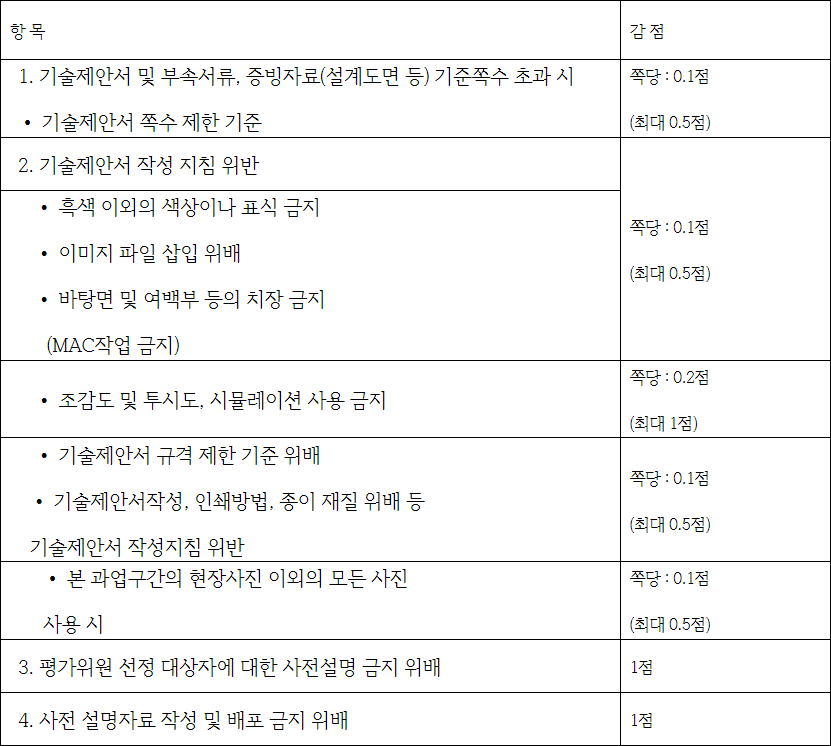

In [20]:
sample_ds['image']

In [21]:
sample_ds['conversations']

[{'role': 'user',
  'content': '[{"type": "image"}, {"type": "text", "text": "지방자치단체 기술제안입찰 등의 감점처리기준에서 조감도 및 투시도, 시뮬레이션 사용 금지의 감점은 몇 점이니"}]'},
 {'role': 'assistant',
  'content': '[{"type": "text", "text": "지방자치단체 기술제안입찰 등의 감점처리기준에 따르면 조감도 및 투시도, 시뮬레이션 사용 금지에 대한 감점은 쪽당 0.2점이며, 최대 1점까지 부여됩니다."}]'},
 {'role': 'user',
  'content': '[{"type": "text", "text": "지방자치단체 기술제안입찰 등의 감점처리기준에서 사전 설명자료 작성 및 배포 금지 위배는 감점이 몇 점일까"}]'},
 {'role': 'assistant',
  'content': '[{"type": "text", "text": "지방자치단체 기술제안입찰 등의 감점처리기준에 따르면, 사전 설명자료 작성 및 배포 금지 위배 시 1점이 부여됩니다. 이는 기술제안서 및 부속서류 작성 시 규정에 어긋나거나 위반하는 사항들 중에서 가장 높은 감점 점수입니다. 해당 사항을 준수하지 않았을 경우에는 1점이 감점되니, 제안서 작성 시에는 주의 깊게 준수해야 합니다."}]'},
 {'role': 'user',
  'content': '[{"type": "text", "text": "기술제안입찰 등의 감점처리기준에서 평가위원 선정 대상자에 대한 사전설명 금지 위배의 감점은 몇 점이지"}]'},
 {'role': 'assistant',
  'content': '[{"type": "text", "text": "기술제안입찰 등의 감점처리기준에 따르면, 평가위원 선정 대상자에 대한 사전설명 금지 위배 시 1점의 감점이 부여됩니다."}]'},
 {'role': 'user',
  'content': '[{"type": "text", "text": "기술제안입

In [32]:
sample_ds['metadata'].keys()

dict_keys(['class', 'code', 'created', 'doc_id', 'doc_published', 'doc_source', 'doc_title', 'ori_html', 'sim_html', 'col_num', 'row_num'])

In [39]:
from bs4 import BeautifulSoup
def extract_tables_with_thead(html):
    soup = BeautifulSoup(html, "html.parser")
    tables = soup.find_all("table")
    for tag in soup(["style", "script"]):
        tag.decompose()
    results = []
    for table in tables:
        tds = table.find_all("th", attrs={"rowspan": "1", "colspan": "1"})
        tds += table.find_all("td", attrs={"rowspan": "1", "colspan": "1"})
        tds += table.find_all("tr", attrs={"rowspan": "1", "colspan": "1"})
        for td in tds:
            td.attrs.pop("rowspan", None)
            td.attrs.pop("colspan", None)
            td.string = td.get_text(strip=True)
            
        results.append(str(table))
    return results

In [41]:
extract_tables_with_thead(sample_ds['metadata']['sim_html'])[0]

'<table><tbody><tr><td>항목</td><td>감점</td></tr><tr><td>1. 기술제안서 및 부속서류, 증빙자료(설계도면 등) 기준쪽수 초과 시<br/>∙ 기술제안서 쪽수 제한 기준</td><td>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>2. 기술제안서 작성 지침 위반</td><td rowspan="2">쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>∙ 흑색 이외의 색상이나 표식 금지<br/>∙ 이미지 파일 삽입 위배<br/>∙ 바탕면 및 여백부 등의 치장 금지 (MAC작업 금지)</td></tr><tr><td>∙ 조감도 및 투시도, 시뮬레이션 사용 금지</td><td>쪽당 : 0.2점 (최대 1점)</td></tr><tr><td>∙ 기술제안서 규격 제한 기준 위배<br/>∙ 기술제안서작성, 인쇄방법, 종이 재질 위배 등 <br/>기술제안서 작성지침 위반</td><td>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>∙ 본 과업구간의 현장사진 이외의 모든 사진 사용 시</td><td>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>3. 평가위원 선정 대상자에 대한 사전설명 금지 위배</td><td>1점</td></tr><tr><td>4. 사전 설명자료 작성 및 배포 금지 위배</td><td>1점</td></tr></tbody></table>'

In [57]:
def get_sha256_size(img_input):
    """
    img_input: 파일 경로(str) 또는 PIL.Image.Image 객체 모두 지원
    리턴: (hash, width, height)
    """
    if isinstance(img_input, str):
        img = Image.open(img_input).convert("RGB")
    elif isinstance(img_input, Image.Image):
        img = img_input.convert("RGB")
    else:
        raise ValueError("img_input은 파일 경로나 PIL.Image 객체여야 합니다.")
    width, height = img.size
    arr = np.array(img)
    hash_val = hashlib.sha256(
        arr.tobytes() + str(arr.shape).encode() + str(arr.dtype).encode()
    ).hexdigest()
    return hash_val, width, height

In [60]:
def get_safe_image_hash(path):
    img = Image.open(path).convert("RGB")
    arr = np.array(img)
    meta = f"{arr.shape}{arr.dtype}".encode()
    return hashlib.sha256(arr.tobytes() + meta).hexdigest()

def get_safe_image_hash_from_pil(img: Image.Image) -> str:
    """
    PIL Image 객체에서 바로 픽셀+메타 기반 SHA256 해시 반환
    """
    arr = np.array(img.convert("RGB"))
    meta = f"{arr.shape}{arr.dtype}".encode()
    return hashlib.sha256(arr.tobytes() + meta).hexdigest()

In [103]:
images_dir = "./images"
os.makedirs(images_dir, exist_ok=True)
records = []
error_records = []
for row in tqdm(ds):
    image = row['image']
    width, height = image.size
    if width > 1500 and height > 1500:
        print(f"Skipping large image: {width}x{height}")
        error_records.append(row)
        continue
    sim_html = row['metadata']['sim_html']
    tables = extract_tables_with_thead(sim_html)
    if len(tables) != 1:
        print(f"Skipping row with {len(tables)} tables")
        continue
    table_html = tables[0]
    arr = np.array(image)
    hash = get_safe_image_hash_from_pil(image)
    image_name = f"{hash}.png"
    image_path = os.path.join(images_dir, image_name[:2], image_name)
    os.makedirs(os.path.dirname(image_path), exist_ok=True)
    image.save(image_path, format='JPEG', quality=95)
    records.append({
        "image_path": image_path.replace(images_dir +"/", ""),
        "width": width,
        "height": height,
        "label": table_html,
    })
    

  0%|          | 167/66755 [00:07<1:42:33, 10.82it/s]

Skipping large image: 4634x23690


  2%|▏         | 1195/66755 [00:41<1:26:32, 12.63it/s]

Skipping large image: 3626x11916


  7%|▋         | 4547/66755 [02:34<44:18, 23.40it/s]  

Skipping large image: 1700x1948


  9%|▉         | 6023/66755 [03:21<37:18, 27.14it/s]

Skipping large image: 2978x3591


 17%|█▋        | 11536/66755 [06:19<29:16, 31.43it/s]

Skipping large image: 2074x2383


 26%|██▌       | 17512/66755 [09:32<29:40, 27.66it/s]

Skipping large image: 2978x3591


 34%|███▍      | 22880/66755 [12:24<37:07, 19.70it/s]

Skipping large image: 4619x6695


 41%|████      | 27260/66755 [14:45<20:36, 31.94it/s]

Skipping large image: 2978x3591


 61%|██████▏   | 40963/66755 [22:07<15:24, 27.90it/s]

Skipping large image: 2978x3591


 68%|██████▊   | 45501/66755 [24:41<15:15, 23.22it/s]

Skipping large image: 3575x6113


 76%|███████▌  | 50866/66755 [27:36<09:05, 29.10it/s]

Skipping large image: 2978x3536


 95%|█████████▍| 63116/66755 [34:24<02:12, 27.44it/s]

Skipping large image: 2649x3811


100%|██████████| 66755/66755 [36:28<00:00, 30.50it/s]


In [114]:
df = pd.DataFrame(records)

In [127]:
# image_path 중복 제거
df = df.drop_duplicates(subset=['image_path'])

In [137]:
df.to_parquet("ko_document_table_visual_sft.parquet", index=False)

In [140]:
from glob import glob
len(glob("images/*/*.png"))

51993

In [128]:
# label 중복 찾기
duplicates = df[df.duplicated(subset=['label'], keep=False)]

In [123]:
df[df['image_path'] == '39/39fc40f287ebc324af7708ce6b21729fcf2c8abb952a26a5de1fecf338da965a.png']

,image_path,width,height,label
2,39/39fc40f287ebc324af7708ce6b21729fcf2c8abb952...,831,746,<table><tbody><tr><td>항목</td><td>감점</td></tr><...
29067,39/39fc40f287ebc324af7708ce6b21729fcf2c8abb952...,831,746,<table><tbody><tr><td>항목</td><td>감점</td></tr><...
41141,39/39fc40f287ebc324af7708ce6b21729fcf2c8abb952...,831,746,<table><tbody><tr><td>항목</td><td>감점</td></tr><...
54538,39/39fc40f287ebc324af7708ce6b21729fcf2c8abb952...,831,746,<table><tbody><tr><td>항목</td><td>감점</td></tr><...


In [129]:
duplicates

,image_path,width,height,label
2687,d9/d9c9081c5dd2ddcef6353fd1382cc5affefbabb74fc...,788,379,<table><tbody><tr><td>성과품</td><td>단위</td><td>수...
2738,91/917dfa0216bbbe77b210f00d2eae6d1d5cc9a56ba9a...,876,1011,"<table><tbody><tr><td colspan=""2"">종류</td><td>재..."
5976,f8/f8f6ab13ac83919a65fe806aef175259070aed667d1...,1188,341,<table><tbody><tr><td>성과품</td><td>단위</td><td>수...
19569,67/67452d25dabf07a87c43ea6b5868735ca752bbce2e9...,784,1165,"<table><tbody><tr><td colspan=""2"">종류</td><td>재..."
51349,2a/2a9cf368c4498a1dc574081a626fcff9258bd749e17...,700,453,<table><tbody><tr><td>종류</td><td>항목</td><td>시험...
56554,e3/e3560277824e766eab579190adcbe02be0c5f7393fc...,785,754,"<table><tbody><tr><td colspan=""2"">구분</td><td>조..."
60926,d1/d143d054a301622c31b5a9e3e107e8e83b085b1ca1d...,846,260,<table><tbody><tr><td>종류</td><td>항목</td><td>시험...
62106,e6/e692e8ded91cc63c42be23c6bb9405d6fff2ad12b91...,785,695,"<table><tbody><tr><td colspan=""2"">구분</td><td>조..."


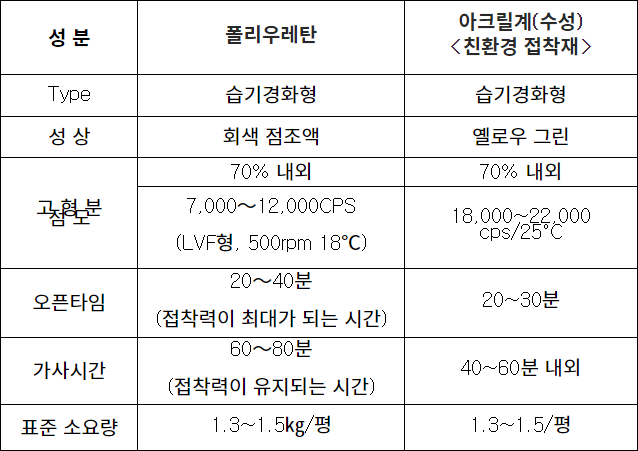

In [46]:
image

In [56]:
tables

['<table><tbody><tr><td>성분</td><td>폴리우레탄</td><td>아크릴계(수성)[친환경 접착재]</td></tr><tr><td>Type</td><td>습기경화형</td><td>습기경화형</td></tr><tr><td>성상</td><td>회색 점조액</td><td>옐로우 그린</td></tr><tr><td rowspan="2">고형분 점도</td><td>70% 내외</td><td>70% 내외</td></tr><tr><td>7,000～12,000CPS(LVF형, 500rpm 18℃)</td><td>18,000~22,000 cps/25°C</td></tr><tr><td>오픈타임</td><td>20～40분(접착력이 최대가 되는 시간)</td><td>20~30분</td></tr><tr><td>가사시간</td><td>60～80분(접착력이 유지되는 시간)</td><td>40~60분 내외</td></tr><tr><td>표준 소요량</td><td>1.3~1.5㎏/평</td><td>1.3~1.5/평</td></tr></tbody></table>']

In [55]:
sample_ds['metadata']['sim_html']

"지방자치단체 입찰시 낙찰자 결정기준<br>제7장 일괄입찰등에의한 낙찰자결정기준 <table><tbody><tr><td>항목</td><td>감점</td></tr><tr><td>1. 기술제안서 및 부속서류, 증빙자료(설계도면 등) 기준쪽수 초과 시<br>∙ 기술제안서 쪽수 제한 기준</td><td>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>2. 기술제안서 작성 지침 위반</td><td rowspan='2'>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>∙ 흑색 이외의 색상이나 표식 금지<br>∙ 이미지 파일 삽입 위배<br>∙ 바탕면 및 여백부 등의 치장 금지 (MAC작업 금지)</td></tr><tr><td>∙ 조감도 및 투시도, 시뮬레이션 사용 금지</td><td>쪽당 : 0.2점 (최대 1점)</td></tr><tr><td>∙ 기술제안서 규격 제한 기준 위배<br>∙ 기술제안서작성, 인쇄방법, 종이 재질 위배 등 <br>기술제안서 작성지침 위반</td><td>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>∙ 본 과업구간의 현장사진 이외의 모든 사진 사용 시</td><td>쪽당 : 0.1점 (최대 0.5점)</td></tr><tr><td>3. 평가위원 선정 대상자에 대한 사전설명 금지 위배</td><td>1점</td></tr><tr><td>4. 사전 설명자료 작성 및 배포 금지 위배</td><td>1점</td></tr></tbody></table>"

In [54]:
sample_ds['metadata']['row_num']

9